First, get database from server.

1. Make a copy of the old app.db if you want.
2. Double click on clickable script copy_scivocab_db_from_server (in this folder) - that will download the database to your computer.
3. Run the commands below. 

In [1]:
import pandas as pd
from typing import List, Dict
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Increase the maximum number of rows displayed to 999
pd.options.display.max_rows=999

# Connect to the database
engine = create_engine("sqlite:///app.db")

def construct_dfs() -> Dict:
    """Create a dictionary of dataframes, keyed by task name"""
    dfs: Dict = {}

    # Populate the dictionary with the dfs
    dfs["breadth"] = pd.read_sql(
        """select
            child_id,
            word.id as word_id,
            breadth_id,
            strand_id,
            word.target as target_word,
            response_type,
            position,
            timestamp
        from breadth_response
        inner join word on 
        breadth_response.word_id=word.id;""",
        engine,
        parse_dates=["timestamp"]
    )

    dfs["depth"] = pd.read_sql(
        """select
            child_id,
            word.id as word_id,
            depth_id,
            strand_id,
            word.target as target_word,
            image_0,
            image_1,
            image_2,
            image_3,
            timestamp
        from depth_response
        inner join word on 
        depth_response.word_id=word.id;""",
        engine,
        parse_dates=["timestamp"]
    )

    dfs["definition"] = pd.read_sql(
        """select
            child_id,
            word.id as word_id,
            definition_id,
            strand_id,
            word.target as target_word,
            text,
            timestamp
        from definition_response
        inner join word on
        definition_response.word_id=word.id;""",
        engine,
        parse_dates=["timestamp"]
    )

    return dfs


def postprocess_depth_df(df) -> None:
    """Replace d..._X.jpg with X in the image_N columns"""
    for i in range(4):
        df[f"image_{i}"] = (
            df[f"image_{i}"].str.split("_").str[1].str.split(".").str[0]
        )


def calculate_depth_item_score(df):
    """Calculate the score for each depth task response"""
    return (
        sum(
            [
                df[f"image_{index}"] == code
                for index, code in zip((0, 1, 2, 3),
                                       ("a", "b", "c", "e"))
            ]
        )
        / 4
    )

def make_depth_fractions_df(dfs):
    """Make a dataframe showing the fractions of depth task image
    types that the participants got correct"""
    records=[]

    for child_id, df in dfs["depth"].groupby(["child_id"]):
        df = df[df["strand_id"] != "training"]
        record = {"child_id": child_id}
        for index, code in zip((0, 1, 2, 3), ("a", "b", "c", "e")):
            filtered = df[f"image_{index}"] == code
            record.update(
                {f"fraction of {code}'s correct" : filtered.sum() / filtered.count()})
        records.append(record)

    result_df = pd.DataFrame(records)
    return result_df

In [2]:
dfs = construct_dfs()
postprocess_depth_df(dfs["depth"])
dfs["depth"]["score"] = calculate_depth_item_score(dfs["depth"])

In [3]:
# Show the breadth task responses
dfs["breadth"]

,child_id,word_id,breadth_id,strand_id,target_word,response_type,position,timestamp
0,9001,wt001,bt001,training,chips,tw,top_left,2021-05-04 22:38:56.451223
1,9001,wt002,bt002,training,car,tw,top_right,2021-05-04 22:40:11.331687
2,9001,w038,b038,50,filament,tw,bottom_left,2021-05-04 22:40:23.514759
3,9001,w051,b051,50,source,tw,bottom_right,2021-05-04 22:40:41.359796
4,9001,w031,b031,50,circuit,tw,bottom_left,2021-05-04 22:40:48.759972
5,9001,w044,b044,50,open circuit,fs,top_left,2021-05-04 22:41:01.223391
6,9001,w043,b043,50,magnetic pole,tw,bottom_right,2021-05-04 22:41:08.584502
7,9001,w035,b035,50,diode,tw,top_left,2021-05-04 22:41:20.067269
8,9001,w048,b048,50,series circuit,tw,top_right,2021-05-04 22:41:29.163097
9,9001,w042,b042,50,magnetic field,tw,bottom_right,2021-05-04 22:41:38.015182


In [4]:
# Show the depth task responses
dfs["depth"]

,child_id,word_id,depth_id,strand_id,target_word,image_0,image_1,image_2,image_3,timestamp,score
0,9001,wt003,dt001,training,bag,a,b,c,e,2021-05-04 22:57:46.782699,1.00
1,9001,wt004,dt002,training,toothbrush,a,b,c,e,2021-05-04 22:59:34.146095,1.00
2,9001,w087,d041,63,condensation,a,b,c,e,2021-05-04 23:00:04.770902,1.00
3,9001,w091,d044,63,ground water,a,b,c,e,2021-05-04 23:00:33.749428,1.00
4,9001,w083,d040,63,atmospheric water,a,b,c,e,2021-05-04 23:01:09.638266,1.00
5,9001,w104,d053,63,transpiration,b,a,c,e,2021-05-04 23:01:35.867223,0.50
6,9001,w101,d050,63,surface water,a,b,c,e,2021-05-04 23:01:59.009965,1.00
7,9001,w105,d052,63,water cycle,a,b,c,e,2021-05-04 23:02:20.531179,1.00
8,9001,w095,d046,63,polar ice cap,a,b,c,e,2021-05-04 23:02:41.544760,1.00
9,9001,w099,d048,63,river,a,b,c,e,2021-05-04 23:03:03.553930,1.00


In [5]:
# Show the definition task responses
dfs["definition"]

,child_id,word_id,definition_id,strand_id,target_word,text,timestamp
0,9001,wt003,None,training,bag,has a handle; is flexible or soft or bends; us...,2021-05-04 23:19:08.363545
1,9001,wt004,None,training,toothbrush,something you use to brush your teeth; has a h...,2021-05-04 23:20:06.889988
2,9001,w059,def028,62,drought,period of time where there's no water; it's dr...,2021-05-04 23:20:58.425798
3,9001,w061,def029,62,erosion,it is a process in which land wears down and t...,2021-05-04 23:22:45.586311
4,9001,w078,def038,62,tornado,a natural disaster that occurs due to a wind v...,2021-05-04 23:23:55.917630
5,9001,w063,def030,62,fault,this is a big crack in plates (tectonic plates...,2021-05-04 23:25:01.551860
6,9001,w065,def032,62,fossil,a imprint in rock that occurs due to compressi...,2021-05-04 23:26:13.262915
7,9001,w087,def041,63,condensation,this occurs ... it's water that forms on the o...,2021-05-04 23:29:37.986987
8,9001,w095,def046,63,polar ice cap,something that's at the north pole; it's a blo...,2021-05-04 23:30:47.568940
9,9001,w083,def040,63,atmospheric water,water in the atmosphere that... it's not neces...,2021-05-04 23:31:48.814345


In [6]:
# Make the fractions dataframe
fractions_df=make_depth_fractions_df(dfs)

# Show the fractions dataframe
fractions_df

,child_id,fraction of a's correct,fraction of b's correct,fraction of c's correct,fraction of e's correct
0,8001,0.812500,0.604167,0.583333,0.770833
1,9001,0.916667,0.833333,0.791667,0.916667
2,9002,0.937500,0.812500,0.770833,0.916667
3,9003,0.854167,0.770833,0.708333,0.791667


In [7]:
# Set plot style
plt.style.use("ggplot")

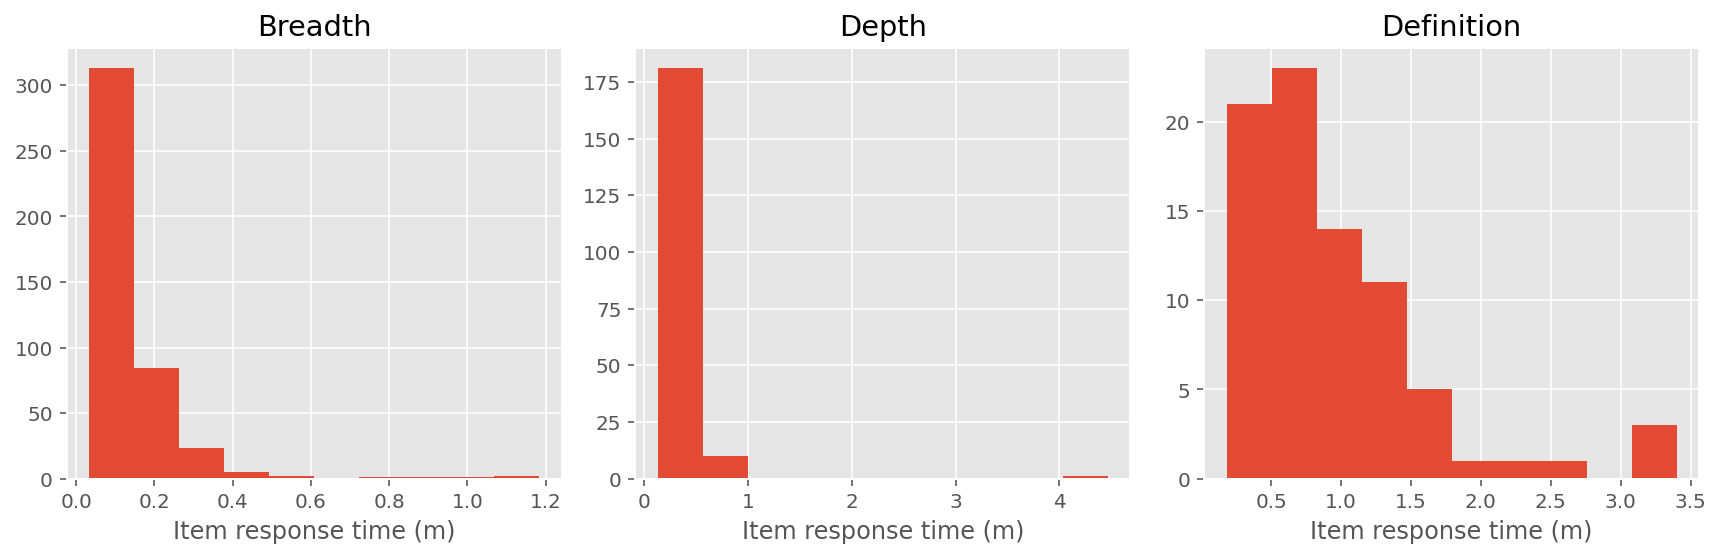

In [8]:
# Histograms of response times by task and item
# Note: This does not take into account the time spent in the fun facts (which is low, but still)
fig, axes = plt.subplots(1, 3, figsize=(12,4))
for i, task in enumerate(("breadth", "depth", "definition")):
    response_times = [
        (((dfs[task].loc[row.Index]["timestamp"]
         - dfs[task].loc[row.Index-1]["timestamp"]).seconds)/60)
        for row in dfs[task].itertuples()
        if row.strand_id != "training"
    ]
    axes[i].hist(response_times, label=f"{task} response times")
    axes[i].set_xlabel("Item response time (m)")
    axes[i].set_title(task.capitalize())

plt.tight_layout()

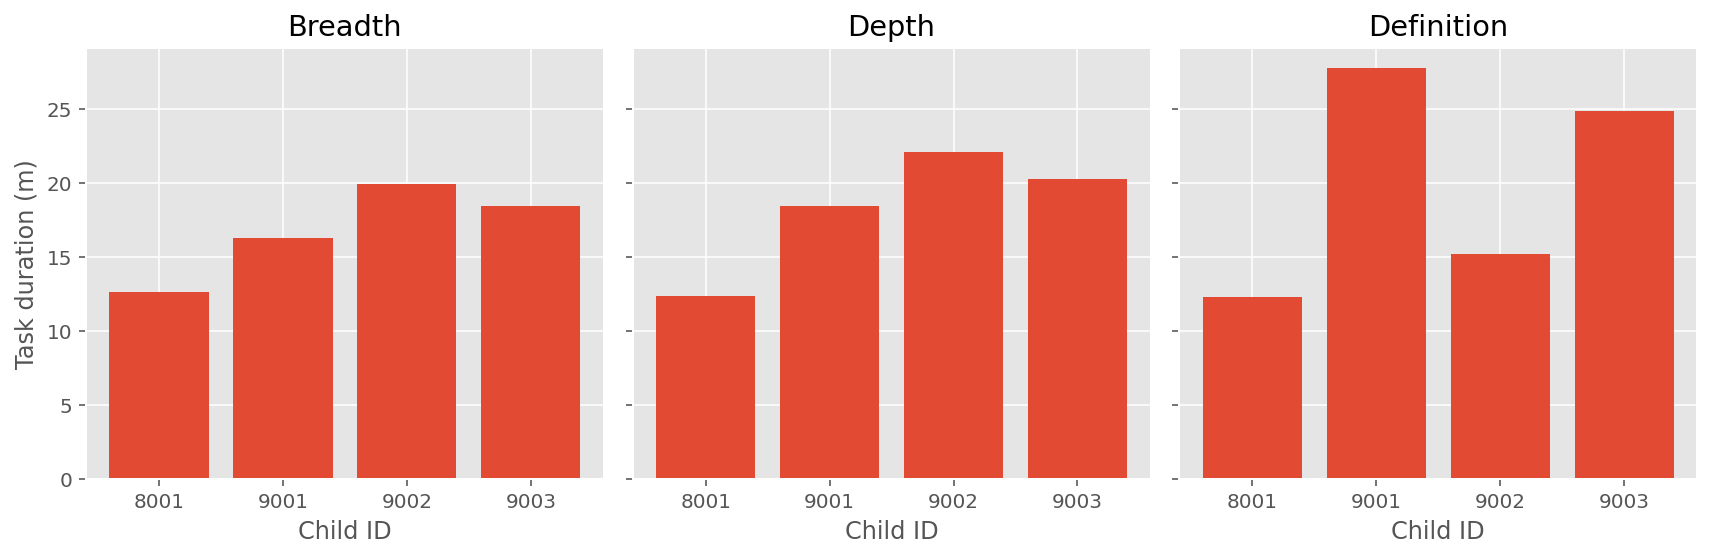

In [9]:
# Bar plots of total times taken for tasks
import numpy as np
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
tasks=("breadth", "depth", "definition")
axes[0].set_ylabel("Task duration (m)")

for i, task in enumerate(tasks):
    timedeltas = []
    child_ids=[]
    for child_id, responses in dfs[task].groupby("child_id"):
        timedelta=(((responses.loc[responses.index[-1]]["timestamp"]
              - responses.loc[responses.index[0]]["timestamp"]).seconds)/60)
        timedeltas.append(timedelta)
        child_ids.append(child_id)
    index = np.arange(len(timedeltas))
    axes[i].bar(index, timedeltas, tick_label=child_ids)
    axes[i].set_xlabel("Child ID")
    axes[i].set_title(task.capitalize())
    
plt.tight_layout()